In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [11]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 2 1 0 0 0 0 1 0 1 0 2 1 1]


[[[189. 180. 183.]
  [190. 181. 184.]
  [193. 184. 187.]
  ...
  [162. 155. 162.]
  [159. 152. 159.]
  [157. 150. 157.]]

 [[186. 177. 180.]
  [186. 177. 180.]
  [187. 178. 181.]
  ...
  [161. 154. 161.]
  [159. 152. 159.]
  [158. 151. 158.]]

 [[184. 175. 178.]
  [182. 173. 176.]
  [182. 173. 176.]
  ...
  [159. 152. 159.]
  [159. 152. 159.]
  [159. 152. 159.]]

 ...

 [[151. 140. 138.]
  [145. 134. 132.]
  [159. 148. 146.]
  ...
  [110.  99. 105.]
  [127. 116. 122.]
  [143. 132. 138.]]

 [[153. 142. 140.]
  [150. 139. 137.]
  [156. 145. 143.]
  ...
  [109.  98. 104.]
  [127. 116. 122.]
  [138. 127. 133.]]

 [[155. 144. 142.]
  [153. 142. 140.]
  [144. 133. 131.]
  ...
  [120. 109. 115.]
  [125. 114. 120.]
  [119. 108. 114.]]]


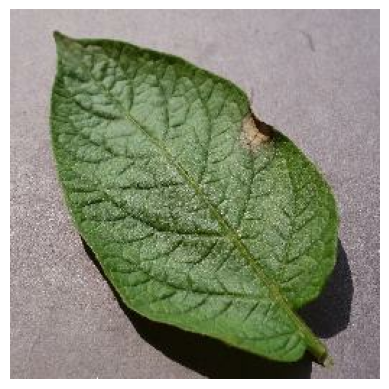

In [13]:
for image_batch, label_batch in dataset.take(1):
    # without .numpy() functio it give tensor

    print(image_batch[0].numpy())
    # image_batch[0].numpy() it gives 3D array

    # these values are float we have to convert them into int using astype() function
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")


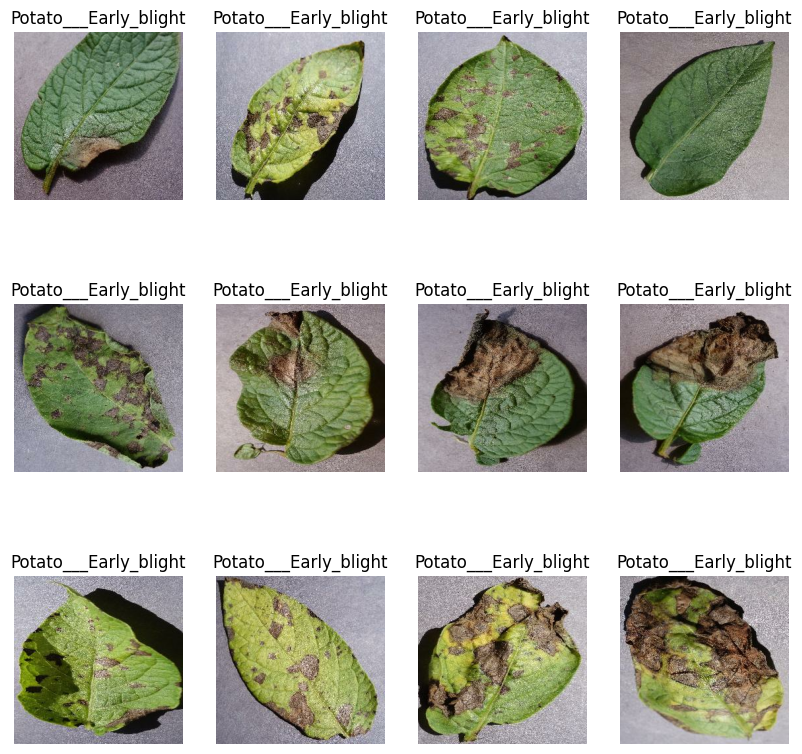

In [14]:
# plt.figure(figsize = (10,10)) WE USED IT SO THE IMAGES DONT OVERLAP BELOW
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    # we onnly took 12 images from teh dataset to print beacuse 32 will ake it difficult
    for i in range(12):
        # subplot help us to plot multiple images at a time
        ax = plt.subplot(3,4,i+1)

        # without .numpy() functio it give tensor
        # these values are float we have to convert them into int using astype() function
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[1]])
        plt.axis("off")

In [15]:
len(dataset)

68

***80% ==> training***

***20% ==> 10% validation, 10% testing***

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        # seed is just for predictibilty, if you do same seed everytime you get same result
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
# cache() it will read the image from the disk and then for the next iteration it will keep the image in the memory so this improve the performance
# prefetch(), if you are using GPU and CPU, if GPU is busy training prefetch will load the next set of batch from the disk and that will improve the performance
# buffer_size = tf.data.AUTOTUNE using this i am letting tensorflow determine how any batches to load you know while GPU is training

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
# Now after the above step my dataset are kind of optimized for training performance thus training will run fast

*** ***

In [23]:
resize_and_rescale = tf.keras.Sequential([
    # here we did resizing using this api
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),

    # here we have done scaling of the image with this api
    layers.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [30]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# print(input_shape)
n_classes = 3


model = models.Sequential([
    # resize_and_rescale,
    layers.Input(shape=input_shape),

    # Convolutional Layers
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    # layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Neural Network
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),

])

model.build(input_shape = (32,input_shape))

In [31]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7755 - loss: 0.5215 - val_accuracy: 0.8594 - val_loss: 0.3458
Epoch 2/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8804 - loss: 0.2846 - val_accuracy: 0.9688 - val_loss: 0.1123
Epoch 3/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9243 - loss: 0.1778 - val_accuracy: 0.8958 - val_loss: 0.2666
Epoch 4/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9431 - loss: 0.1658 - val_accuracy: 0.8802 - val_loss: 0.4009
Epoch 5/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9282 - loss: 0.1757 - val_accuracy: 0.9583 - val_loss: 0.1312
Epoch 6/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9525 - loss: 0.1192 - val_accuracy: 0.9583 - val_loss: 0.1159
Epoch 7/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9326 - loss: 0.1541 - val_accuracy: 0.9740 - val_loss: 0.0655
Epoch 8/25
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9563 - loss: 0.1162 - val_accuracy: 0.9427 - v

In [35]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9375 - loss: 0.2064


[0.19714942574501038, 0.9453125]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

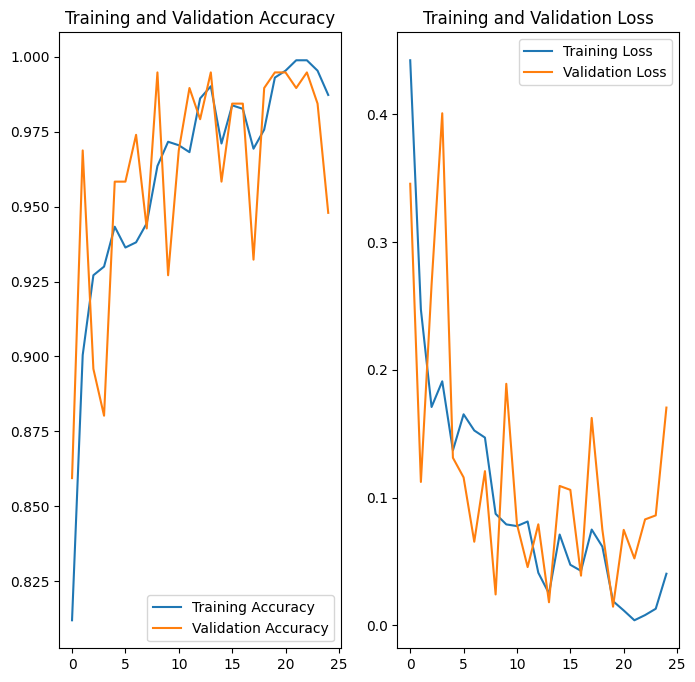

In [41]:
EPOCHS = 25
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


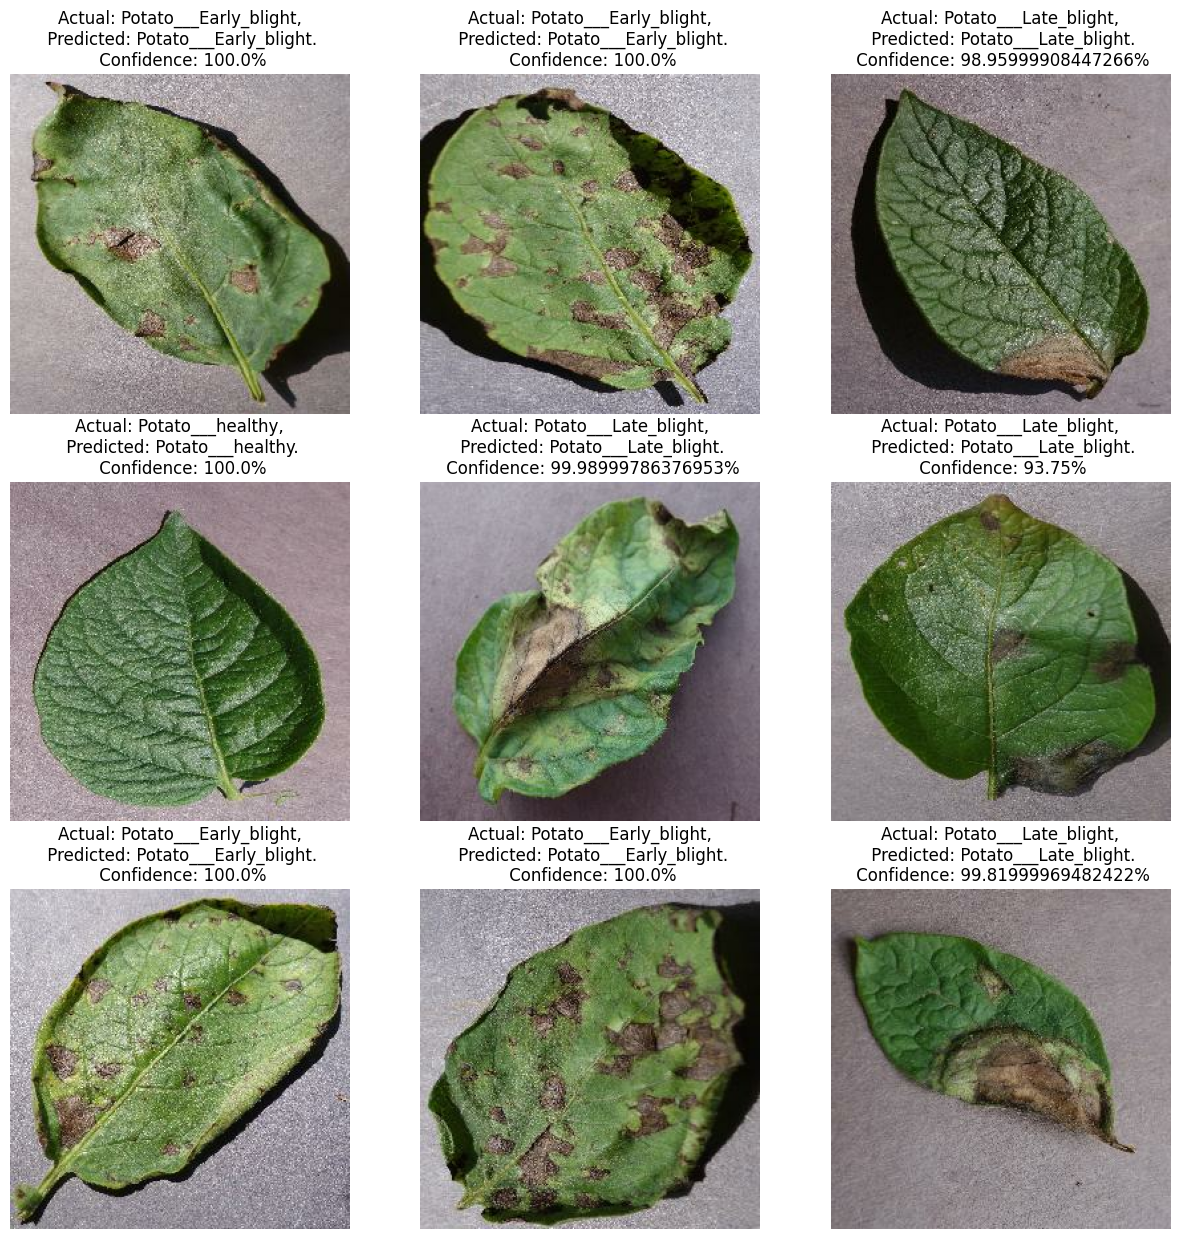

In [44]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [38]:
model.save(".\model.h5")

In [39]:
model.save(".\model.keras")